In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import json
import os

In [2]:
## En esta notebook estan ...

# El universo (base) de analisis pueden ser:
#     - [P] Personas
#     - [H] Hogares
#     - [M] Mayores de 24
#     - [Hp] Hogares en pobreza
#     - [Hi] Hogares en indigencia

# Ademas restringido a un espacio geografico:
#     - ['AMBA'] i.e. data.loc[data.AGLOMERADO.isin([33, 32, 2])]

# Las variables agrupadoras pueden ser: 
#     - ['Q', 'Grupo Etario']
#     - ['Q','Total pais']
#     - ['Q','AGLOMERADO']
#     - ['Q','PROV']
#     - ['Q','AGLO_si']
#     - ['Q','P0910']
#     - ['Q','DPTO']
#     - ['Q','Region']


# Las variables de resultado pueden ser: (variable, sintetico, base)
#     - ["Pobreza", "mean", "Personas"]
#     - ["Pobreza", "sum", "Personas"]
#     - ["Indigencia", "mean", "Personas"]
#     - ["Indigencia", "sum", "Personas"]


In [29]:
### Sintetizadores

## Base Personas
def sintetizar_P(data, grouper, frac = 0.02):
    df = data.copy()
    df['Total'] = True
    df['timestamp'] = dt.datetime.today()
    
#     # Funciones percentil
#     percentiles = [.10, .25, .75, .9, .2]
#     quantile_funcs = [(p, lambda x: x.quantile(p)) for p in percentiles]

    df = df.groupby(grouper + ['timestamp'])[['Total', 'Pobreza', 'Indigencia','P47T_persona']].agg(
        {'Total': ['mean', 'sum'], 'Pobreza': ['mean', 'sum'], 'Indigencia': ['mean', 'sum'], 
         'P47T_persona':['mean', q10, q25, 'median', q75, q90]})
    
    df[[('Total', 'sum')]] = (df[[('Total', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Pobreza', 'sum')]] = (df[[('Pobreza', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Indigencia', 'sum')]] = (df[[('Indigencia', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Total', 'mean')]] = df[[('Total', 'mean')]].round(4)
    df[[('Pobreza', 'mean')]] = df[[('Pobreza', 'mean')]].round(4)
    df[[('Indigencia', 'mean')]] = df[[('Indigencia', 'mean')]].round(4)
    
    df['P47T_persona'] = df['P47T_persona'].round(-1).astype(int)
    
    dfB = df.T.set_index(np.repeat('Personas', df.shape[1]), append=True)
       
#     dfB = dfB.stack().stack().stack().reset_index()
    stacker_ix = [-i for i in range(len(grouper) + 1)]
    dfB = dfB.stack(level = stacker_ix).reset_index()
    
    dfB = dfB.rename(columns = {'level_0': 'observable', 'level_1': 'sintetico', 'level_2': 'base', 0: 'valor'})
    return dfB

def sintetizar_H(data, grouper, frac = 0.02):
    df = data.copy()
    df = df.groupby('HOGAR_REF_ID').first()
    df['Total'] = True
    df['timestamp'] = dt.datetime.today()

#     # Funciones percentil
#     percentiles = [.10, .25, .75, .9, .2]
#     quantile_funcs = [(p, lambda x: x.quantile(p)) for p in percentiles]

    df = df.groupby(grouper + ['timestamp'])[['Total', 'Pobreza', 'Indigencia', 'P47T_hogar', 'CB_EQUIV', 'CBA', 
                                              'gap_indigencia', 'CBT', 'gap_pobreza']
                            ].agg(
    {'Total': ['mean', 'sum'], 'Pobreza': ['mean', 'sum'], 'Indigencia': ['mean', 'sum'], 
     'P47T_hogar': ['mean', q10, q25, 'median', q75, q90],
     'CB_EQUIV': ['mean', 'median'],     
     'CBA': ['mean', 'median'], 'gap_indigencia': ['mean', 'median'], 
     'CBT': ['mean', 'median'], 'gap_pobreza': ['mean', 'median']})
        
    df[[('Total', 'sum')]] = (df[[('Total', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Pobreza', 'sum')]] = (df[[('Pobreza', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Indigencia', 'sum')]] = (df[[('Indigencia', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Total', 'mean')]] = df[[('Total', 'mean')]].round(4)
    df[[('Pobreza', 'mean')]] = df[[('Pobreza', 'mean')]].round(4)
    df[[('Indigencia', 'mean')]] = df[[('Indigencia', 'mean')]].round(4)

    df['CB_EQUIV'] = df['CB_EQUIV'].round(4)
    
    df['P47T_hogar'] = df['P47T_hogar'].round(-1).astype(int)
    df['CBA'] = df['CBA'].round(-1).astype(int)
    df['gap_indigencia'] = df['gap_indigencia'].round(-1).astype(int)
    df['CBT'] = df['CBT'].round(-1).astype(int)
    df['gap_pobreza'] = df['gap_pobreza'].round(-1).astype(int)
    
    dfC = df.T.set_index(np.repeat('Hogares', df.shape[1]), append=True)
    dfC.index.names = ['observable', 'sintetico', 'base']
    
#     FrozenList(['observable', 'sintetico', 'base', 'timestamp', 'AGLOMERADO', 'Region', 'Q'])
    
# #     dfC = dfC.stack().stack().stack().reset_index()
    stacker_ix = [-i for i in range(len(grouper) + 1)]
    dfC = dfC.stack(level = stacker_ix).reset_index()
#     # es como df.stack([-1, -2, -3, -4]) pero se adapta a groupers mas o menos largos
#     dfC = dfC.stack(stacker_ix).reset_index()

    dfC = dfC.rename(columns = {'level_0': 'observable', 'level_1': 'sintetico', 'level_2': 'base', 0: 'valor'})
    return dfC

# Percentile funcs
def q10(x):
    return x.quantile(0.1)

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def q90(x):
    return x.quantile(0.9)

In [16]:
import glob
frac = 0.02
# path ='./data/RFReg_' # use your path
path ='./../data/Pobreza/pobreza_' # use your path

allFiles = []
allFiles += glob.glob(path+str(frac)+'_q*.csv')
allFiles = sorted(allFiles)
allFiles

['./../data/Pobreza/pobreza_0.02_q2019-02-15.csv',
 './../data/Pobreza/pobreza_0.02_q2019-05-15.csv',
 './../data/Pobreza/pobreza_0.02_q2019-08-15.csv',
 './../data/Pobreza/pobreza_0.02_q2019-11-15.csv',
 './../data/Pobreza/pobreza_0.02_q2020-02-15.csv',
 './../data/Pobreza/pobreza_0.02_q2020-05-15.csv',
 './../data/Pobreza/pobreza_0.02_q2020-08-15.csv']

In [17]:
pd.options.display.max_rows = 99

In [18]:
# # data = pd.read_csv('./../data/Pobreza/pobreza_0.02_q2020-08-15.csv')
    
# df = sintetizar_H(data.sample(1000), grouper = ['Region'])
# # df.head()
# # df
# df = df.loc[df.observable.isin(['P47T_hogar', 'CBA', 'CBT'])]
# # df['Q'] = pd.to_datetime(info['Q'])
# # df = df.set_index(['observable', 'sintetico'])['valor'].unstack()
# df

In [19]:
if not os.path.exists('./../data/results'):
    os.makedirs('./../data/results')

def add_to_json(synth_func, data, grouper, base_str):
        df = synth_func(data, grouper)
        filename = './../data/results/result_'+base_str+'_'+'-'.join(grouper)+'.json'
#         print(filename)
        if not os.path.exists(filename):
            df.to_json(filename, orient="records")
        else:
            df_ = pd.concat([df, pd.read_json(filename)])
            df_.to_json(filename, orient="records")

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# Las variables agrupadoras pueden ser: 
groupers = [['Q','Total_pais'], ['Q','AGLO_si'], ['Q','AGLOMERADO'], ['Q','Region'], ['Q','Region', 'AGLO_si'], 
            ['Q', 'Region', 'AGLOMERADO'], ['Q','PROV'], ['Q','DPTO'],
            ['Q', 'Grupo_Etario_3'], ['Q', 'Grupo_Etario_INDEC'], ['Q', 'Grupo_Etario_q10'], 
            ['Q','P0910']]

# groupers = [['Q', 'Region', 'AGLOMERADO']]

for f in allFiles:
    print(f)
#     filename = './../data/Pobreza/pobreza_0.02_q2003-08-15.csv'
    data = pd.read_csv(f)
    data['AGLO_si'] = data.AGLOMERADO != 0
    data['Total_pais'] = True
    
#     for grouper in groupers:
#         add_to_json(sintetizar_P, data, grouper, base_str = 'P')
        
#     for grouper in groupers:
#         add_to_json(sintetizar_P, data.loc[data.AGLO_si], grouper, base_str = 'PAGLO')

#     for grouper in groupers:
#         add_to_json(sintetizar_P, data.loc[data.P03 >= 24], grouper, base_str = 'M24')
        
    for grouper in groupers:
        add_to_json(sintetizar_H, data, grouper, base_str = 'H')
        
    for grouper in groupers:
        add_to_json(sintetizar_H, data.loc[data.Pobreza], grouper, base_str = 'Hp')
        
    for grouper in groupers:
        add_to_json(sintetizar_H, data.loc[data.Indigencia], grouper, base_str = 'Hi')
        

./../data/Pobreza/pobreza_0.02_q2019-02-15.csv
./../data/Pobreza/pobreza_0.02_q2019-05-15.csv
./../data/Pobreza/pobreza_0.02_q2019-08-15.csv
./../data/Pobreza/pobreza_0.02_q2019-11-15.csv
./../data/Pobreza/pobreza_0.02_q2020-02-15.csv
./../data/Pobreza/pobreza_0.02_q2020-05-15.csv
./../data/Pobreza/pobreza_0.02_q2020-08-15.csv


./../data/results/result_P_Q-Total_pais.json


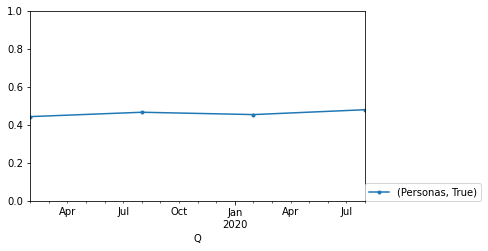

./../data/results/result_P_Q-AGLO_si.json


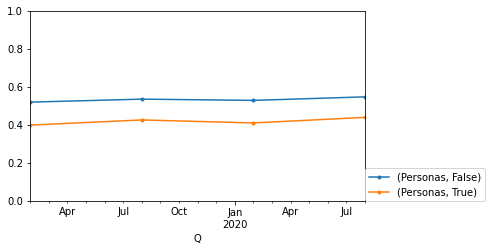

./../data/results/result_P_Q-AGLOMERADO.json


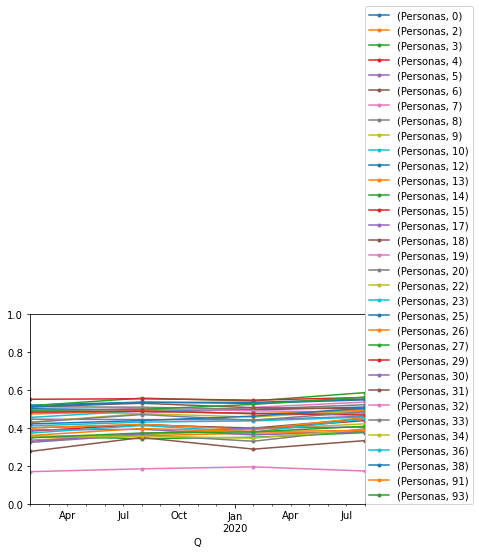

./../data/results/result_P_Q-Region.json


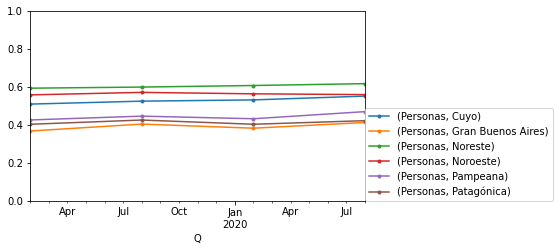

./../data/results/result_P_Q-Region-AGLO_si.json


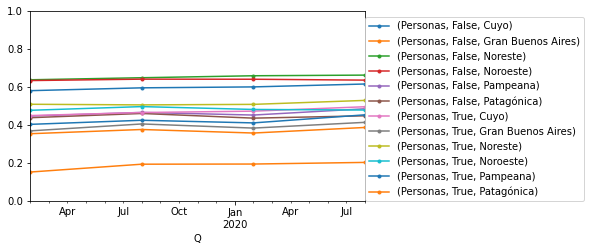

./../data/results/result_P_Q-Region-AGLOMERADO.json


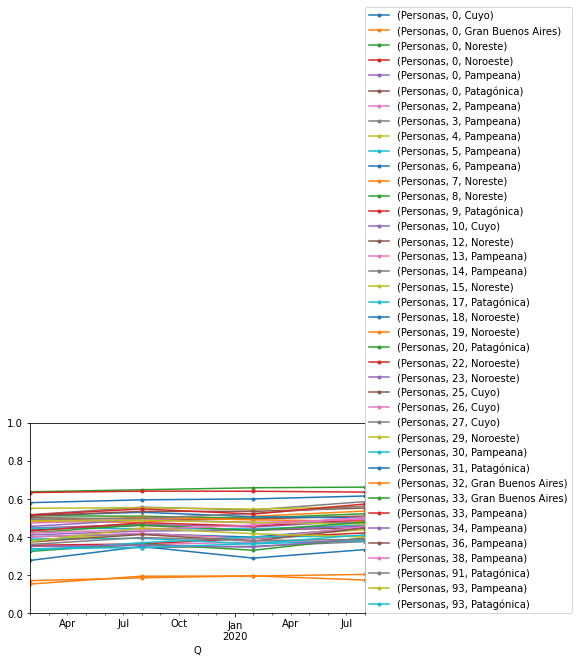

./../data/results/result_P_Q-PROV.json


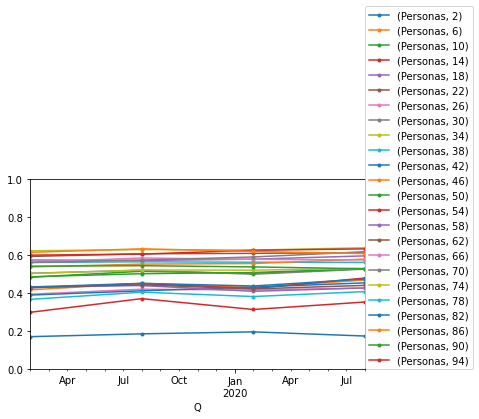

./../data/results/result_P_Q-DPTO.json


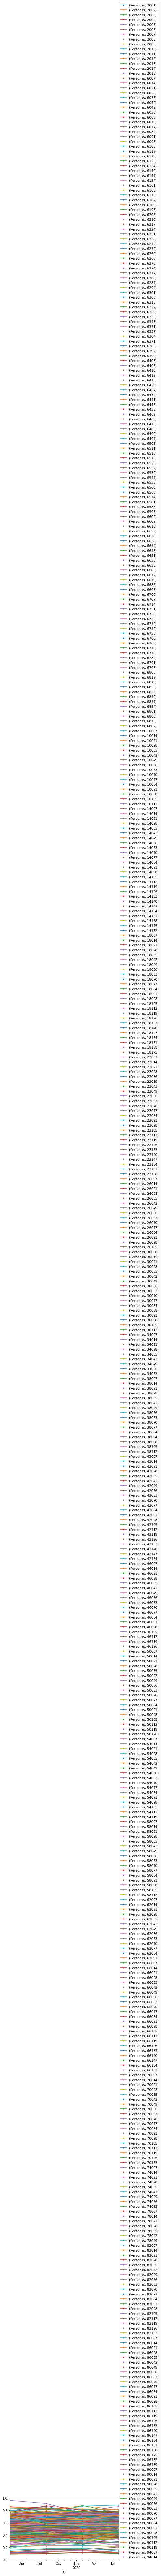

./../data/results/result_P_Q-Grupo_Etario_3.json


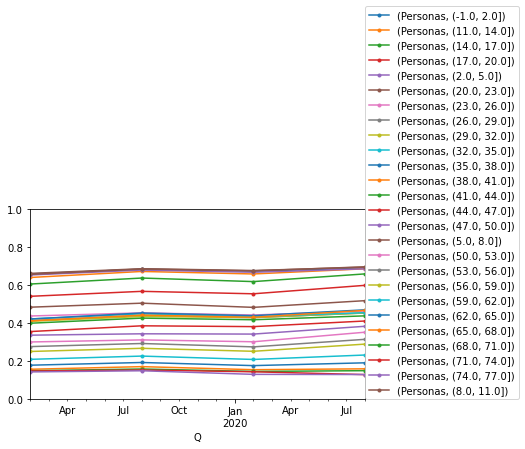

./../data/results/result_P_Q-Grupo_Etario_INDEC.json


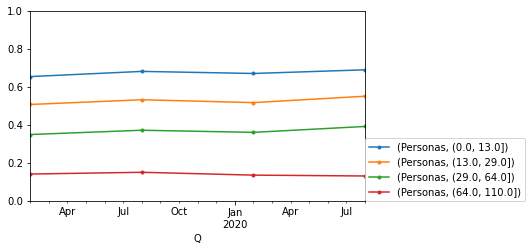

./../data/results/result_P_Q-Grupo_Etario_q10.json


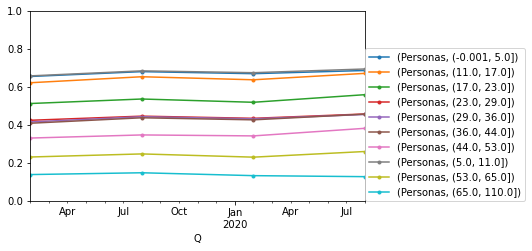

./../data/results/result_P_Q-P0910.json


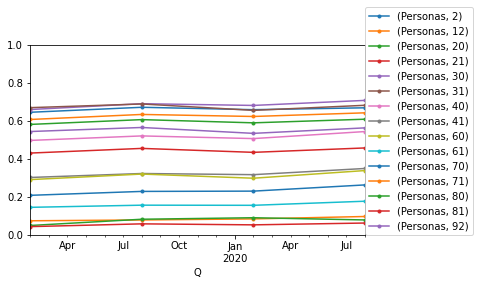

In [10]:
base_str = 'P'
for grouper in groupers:
    file = './../data/results/result_'+base_str+'_'+'-'.join(grouper)+'.json'
    print(file)
    info = pd.read_json(file).drop('timestamp', axis = 1).drop_duplicates()

    info['Q'] = pd.to_datetime(info['Q'])

    # Mean pobreza, indigencia
    info_ = info.loc[info.sintetico == 'mean'].set_index(['observable'] + grouper)['valor']
#     plot_data = info_.unstack([1]).T

    ## Columnas que no son ni el trimestre ni el valor. Identifican las series de tiempo.
    time_series_cols = list(col for col in info.columns if col not in ['Q', 'valor'])
    plot_data = info.groupby([pd.Grouper(freq = '6M', key='Q')] + time_series_cols).agg({'valor': 'mean'}).unstack(0)['valor'].T
    
    if len(plot_data) < 50:
        fig, axs = plt.subplots(1, figsize = (6, 3.5))
#         plot_data.plot(ax = axs, marker = '.')
        plot_data['Pobreza']['mean'].plot(ax = axs, marker = '.')
        axs.legend(loc = (1, 0))
        axs.set_ylim(0, 1)
        plt.show()

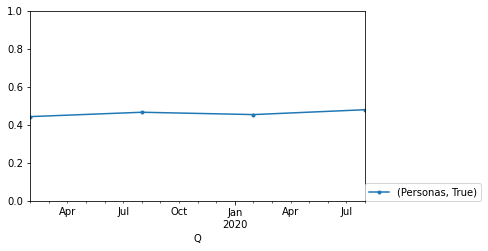

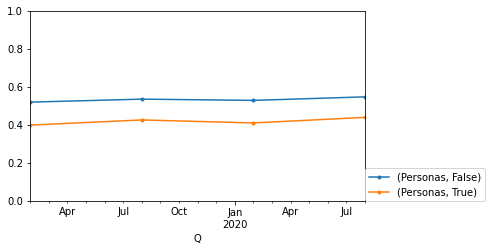

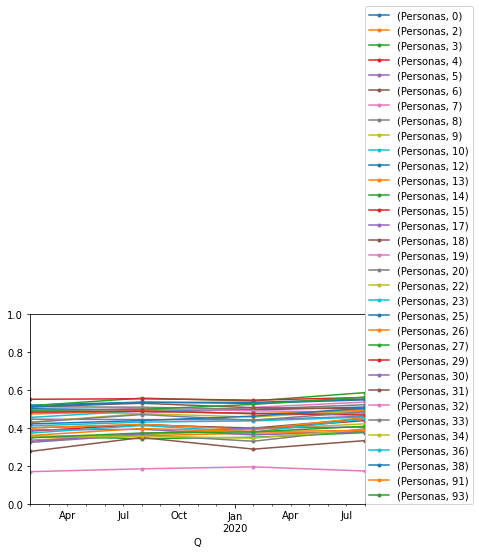

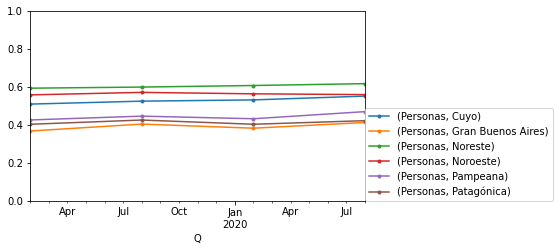

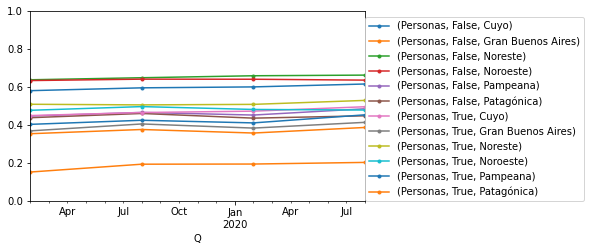

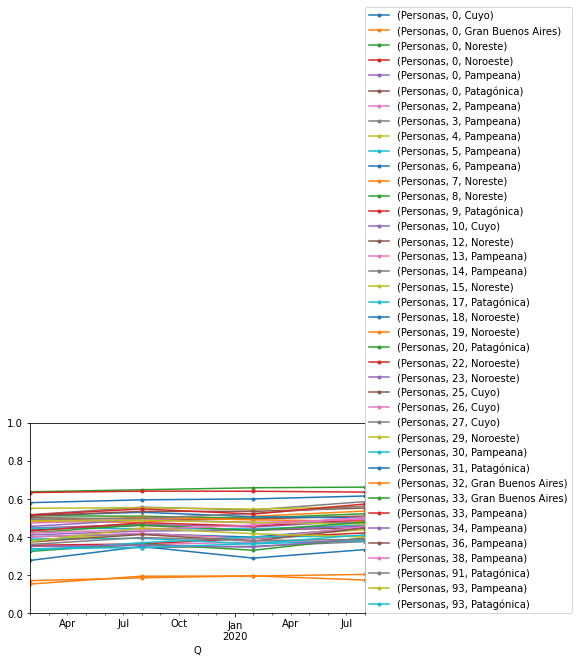

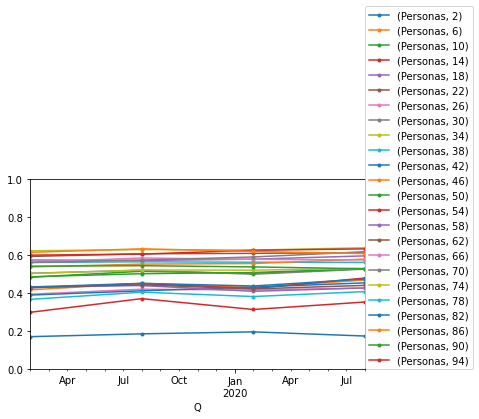

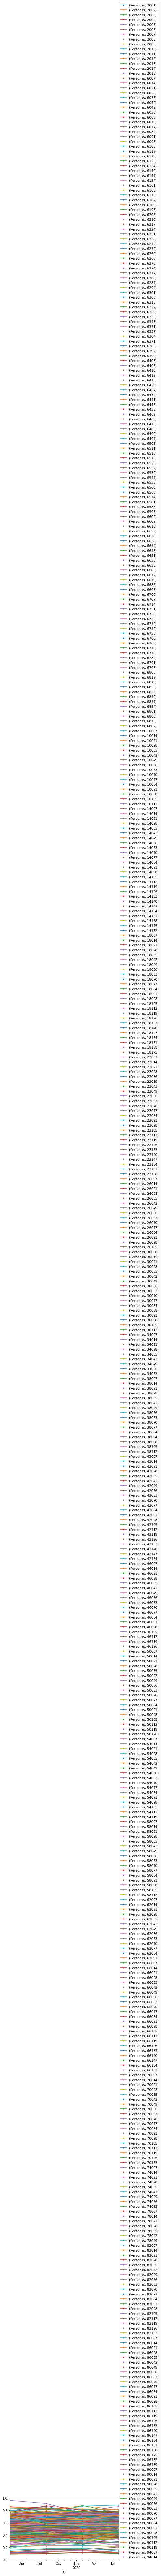

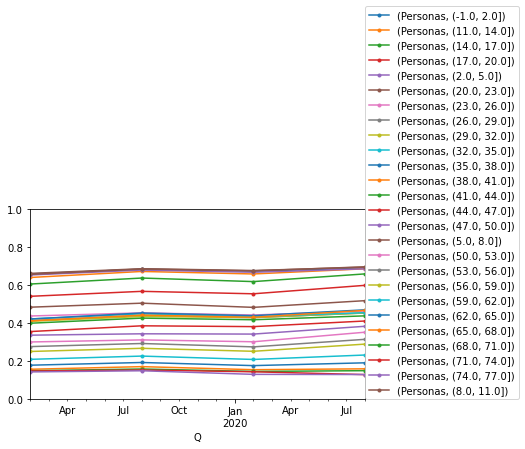

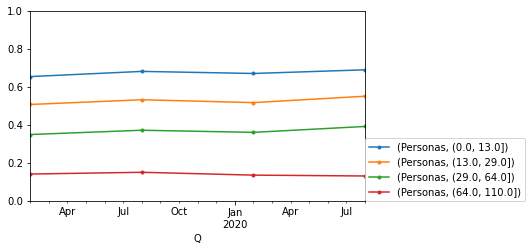

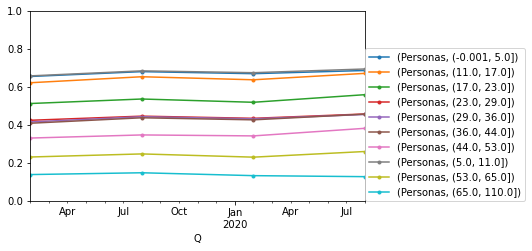

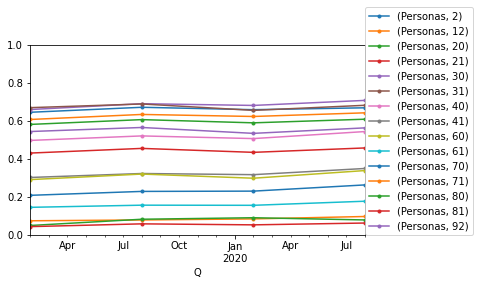

In [11]:
for grouper in groupers:
    info = pd.read_json('./../data/results/result_'+base_str+'_'+'-'.join(grouper)+'.json').drop('timestamp', axis = 1).drop_duplicates()
    
    info['Q'] = pd.to_datetime(info['Q'])
    
    # Mean pobreza, indigencia
    
    info_ = info.loc[info.sintetico == 'mean'].set_index(['observable'] + grouper)['valor']
#     plot_data = info_.unstack([1]).T
    
    ## Columnas que no son ni el trimestre ni el valor. Identifican las series de tiempo.
    time_series_cols = list(col for col in info.columns if col not in ['Q', 'valor'])
    plot_data = info.groupby([pd.Grouper(freq = '6M', key='Q')] + time_series_cols).agg({'valor': 'mean'}).unstack(0)['valor'].T
    
    if len(plot_data) < 50:
        fig, axs = plt.subplots(1, figsize = (6, 3.5))
#         plot_data.plot(ax = axs, marker = '.')
        plot_data['Pobreza']['mean'].plot(ax = axs, marker = '.')
        axs.legend(loc = (1, 0))
        axs.set_ylim(0, 1)
        plt.show()
        
#     # Median salario

#     info_ = info.loc[info.sintetico == 'median'].set_index(['observable'] + grouper)['valor']

#     plot_data = info_.unstack([1]).T
    
#     if info_.unstack([1]).T.shape[1] < 50:
#         fig, axs = plt.subplots(1, figsize = (6, 3.5))
#         plot_data.plot(ax = axs, legend = False, marker = '.')
#         axs.legend(loc = (1, 0))
# #         axs.set_ylim(0, 1)
#         axs.set_ylim(0, 8000)
#         plt.show()

In [12]:
### Se carga la informacion de condiciones de pobreza de cada cuatrimestre y computa el valor sintetico (ej. pobreza por provincia/aglomerado)

In [13]:
## Se ahorra algo de tiempo eligiendo las columnas a importar..

# %%timeit
# pd.read_csv(f)

# 2.09 s ± 49.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# %%timeit
# pd.read_csv(f, usecols = grouper + ['Pobreza', 'Indigencia', 'P03', 'P47T_persona', 'HOGAR_REF_ID', 'P47T_hogar', 'CBA', 'CBT', 'gap'])

# 1.31 s ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

#  pero parece que conviene usar el siguiente loop donde cada info trimestral que se carga se agrupa, y luego se juntan los resultados: